In [1]:
import numpy as np
from numpy.matlib import repmat
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import multitest
import sys
sys.path.insert(1, "../utilities")
from plot_utils import *
from reliability import *
from n_effective import *
from VAT_simple import *
from MWSL import *
from correlation_test import *
LINEMARK = '---------------------------------------------------------------------------------------'

In [2]:
def save_ttest(featureInfo, p_FDR, p_uncorrected, fc, minmargin, significant, patterns, pattern_inds, countsX, countsY, fname_out, header=None):
    
    # add a header to the output file if one is not provided    
    if header is None:
        header = " compound; masstime; test; p_orig; p_FDR; p_Bonf; FC; ms; gaps1; gaps2\n"
    # add ".csv" to the end of the filename if it's not already there
    if fname_out[-4:] != '.csv':
        fname_out += '.csv'
    p_Bonf = p_uncorrected * len(p_uncorrected)
    p_Bonf[p_Bonf>1] = 1
    # write the header
    i=0
    with open(fname_out, 'w') as f:
        f.write(header)
        while i < len(p_uncorrected):
            if significant[i]:
                # write the above in oneline
                f.write('%s;%s@%s;%s;%f;%f;%f;%f;%f;%d;%d\n' % (featureInfo[i,0],\
                                                                featureInfo[i,4],\
                                                                featureInfo[i,5],\
                                                                patterns[pattern_inds[i]],\
                                                                p_uncorrected[i],\
                                                                p_FDR[i],\
                                                                p_Bonf[i],\
                                                                fc[i],\
                                                                minmargin[i],\
                                                                countsX[i],\
                                                                countsY[i]))
            i+=1

    f.close()
    

In [3]:
path = '../../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/'
filenames = [line.rstrip() for line in open(path +'filenames.txt')]
filenames

['cellsRPnegGFstatus.csv',
 'cellsRPposGFstatus.csv',
 'cellshilicnegGFstatus.csv',
 'cellshilicposGFstatus.csv',
 'cellslipidnegGFstatus.csv',
 'cellslipidposGFstatus.csv',
 'mediumRPnegGFstatus.csv',
 'mediumRPposGFstatus.csv',
 'mediumhilicnegGFstatus.csv',
 'mediumhilicposGFstatus.csv']

In [9]:
# SET FILE NUMBER and FILE NAME
fnum=2
fname = filenames[fnum].split('GF')[0]

# SET PARAMETERS
ALPHA=0.05

KEEP_ALL=False # whether to keep all results or just those with FC > MINFC
MINFC=1

MINVAR=0.125
PRUNE=True # drop tests with one or both tests having the number of un-acceptable values above tol

tol = 0.8
accept = [0, 8, 64, 128]

# SAVE (MANUAL SWITCH'S)
SAVE=False
KEEP_INSIGNIFICANT=False # keeps all p values not just significant

FOLDER_OUT = './results/'

if KEEP_ALL:
    FNAME_OUT = FOLDER_OUT + fname + "ALPHA" + str(ALPHA) + "MINVAR" + str(MINVAR) + ".csv"
else:
    FNAME_OUT = FOLDER_OUT + fname + "ALPHA" + str(ALPHA) + "FC" + str(MINFC) + "MINVAR" + str(MINVAR) + ".csv"

In [10]:
# Print parameters
print(LINEMARK)
print("FILENAME: ", fname)
if SAVE:
    print("SAVING TO: ", FNAME_OUT)
print('\nPARAMETERS:')
print('ALPHA =', ALPHA)
print('KEEP_ALL =', KEEP_ALL)
print('MINFC =', MINFC)
print('MINVAR =', MINVAR)
print('PRUNE =', PRUNE)
print('SAVE =', SAVE)
print('KEEP_INSIGNIFICANT =', KEEP_INSIGNIFICANT)

---------------------------------------------------------------------------------------
FILENAME:  cellshilicneg

PARAMETERS:
ALPHA = 0.05
KEEP_ALL = False
MINFC = 1
MINVAR = 0.125
PRUNE = True
SAVE = False
KEEP_INSIGNIFICANT = False


In [11]:
# READ THE DATA
df = pd.read_csv(path + filenames[fnum],sep=';', header=None)

patterns = ["aSYN--UT", "comb.--UT", "INFg--UT", "aSYN--INFg","comb.--INFg.", "aSYN--comb."]
n_patterns = len(patterns)


# Compile the data for testing
AREA = df.iloc[3:,8:48].to_numpy(dtype=float)
GROUPS = df.iloc[0,8:48].to_numpy(dtype=str)
GAP = df.iloc[3:,88:].to_numpy(dtype=int)
FEATURE_INFO = df.iloc[3:,:8].to_numpy(dtype=str)
n_tests_init = AREA.shape[0]*n_patterns
n_features_init = AREA.shape[0]

# APPLY THE VARIANCE FILTER TO BOTH AREA AND GAP data
# and update the feature info (account dropped features)
variance = np.var(AREA, axis=1, ddof=1)
AREA = AREA[variance >= MINVAR,:]
GAP = GAP[variance >= MINVAR,:]
FEATURE_INFO = FEATURE_INFO[variance >= MINVAR,:]
variance = variance[variance >= MINVAR][:,np.newaxis]
n_tests_after_var = AREA.shape[0]*n_patterns
n_features_after_var = AREA.shape[0]

# Compile test identifiers, that map test/row to test identifier string (for possible later use)
I = np.ones((AREA.shape[0],1), dtype=int)
pattern_inds = np.vstack((0*I, 1*I, 2*I, 3*I, 4*I, 5*I)).flatten()
#  and expand the variance and info to match the testsize (for possible later use)
FULL_VARIANCE = repmat(variance, n_patterns, 1)
FULL_FEATURE_INFO = repmat(FEATURE_INFO, n_patterns, 1)

# Compile the data for testing
aSYN = AREA[:,0:10]
comb = AREA[:,10:20]
IFNg = AREA[:,20:30]
UT = AREA[:,30:40]

dataX = np.vstack((aSYN, comb, IFNg, aSYN, comb, aSYN))
dataY = np.vstack((UT,   UT,   UT,   IFNg, IFNg, comb))

GAP_aSYN = GAP[:,0:10]
GAP_comb = GAP[:,10:20]
GAP_IFNg = GAP[:,20:30]
GAP_UT = GAP[:,30:40]

gapX = np.vstack((GAP_aSYN, GAP_comb, GAP_IFNg, GAP_aSYN, GAP_comb, GAP_aSYN))
gapY = np.vstack((GAP_UT,   GAP_UT,   GAP_UT,   GAP_IFNg, GAP_IFNg, GAP_comb))

keep, countX, countY = reliability(gapX, gapY, tol=0.8, accept=[0, 8, 64, 128])
n_tests_after_reliability = np.sum(keep)
if PRUNE:
    # Keep only the reliable tests
    dataX=dataX[keep,:]
    dataY=dataY[keep,:]
    
    # same for other information (variance not used at the moment)
    FULL_VARIANCE=FULL_VARIANCE[keep]
    FULL_FEATURE_INFO=FULL_FEATURE_INFO[keep,:]
    pattern_inds=pattern_inds[keep]
    countX=countX[keep]
    countY=countY[keep]
    
# Print the number of tests after pruning
print(LINEMARK)
print("Number of tests before pruning: ", n_tests_init)
print("Number of tests after variance filtering: ", n_tests_after_var)
print("Number of tests after pruning based on missing values (code 32): ", dataX.shape[0])
print("Number of features initially: ", n_features_init)
print("Number of features after variance filtering: ", n_features_after_var)
print("Number of tested features (after filtering and pruning based on reliability): ", int(np.ceil(dataX.shape[0]/n_patterns)))

---------------------------------------------------------------------------------------
Number of tests before pruning:  786
Number of tests after variance filtering:  648
Number of tests after pruning based on missing values (code 32):  583
Number of features initially:  131
Number of features after variance filtering:  108
Number of tested features (after filtering and pruning based on reliability):  98


In [12]:
# Calculate the fold-change and positive minmargin (note: data is already log transformed)
fc = dataX.mean(axis=1) - dataY.mean(axis=1)
minmargin = np.max(np.stack((np.nanmin(dataX, axis=1) - np.nanmax(dataY, axis=1),np.nanmin(dataY, axis=1) - np.nanmax(dataX, axis=1)),axis=1), axis=1)
minmargin = np.clip(minmargin, 0, None)
result = stats.ttest_ind(dataX, dataY, axis=1, equal_var=False, nan_policy='raise')
p_uncorrected = result.pvalue

In [13]:
multitest_method = 'fdr_by'
rejected, p_corrected, alphacSidak, alphacBonf = multitest.multipletests(p_uncorrected, alpha=ALPHA, method=multitest_method)
print(LINEMARK)
print("Number of discoveries with uncorrected p-values: ", np.sum(p_uncorrected < ALPHA))
print("Number of discoveries with B-Y corrected p-values: ", np.sum(p_corrected < ALPHA))
print("Number of discoveries based on Sidak correction: ", np.sum(p_uncorrected < alphacSidak))
print("Number of discoveries based on Bonferroni correction: ", np.sum(p_uncorrected < alphacBonf))
print("Number of discoveries with B-Y corrected p-values and |FC| >=", MINFC, ": ", np.sum((p_corrected < ALPHA) & (np.abs(fc) >= MINFC)))
print("Number of discoveries with B-Y corrected p-values and minmargin > 0 :", np.sum((minmargin > 0) & (p_corrected < ALPHA)))
print("Number of discoveries with B-Y corrected p-values, |FC| >= {}, and minmargin > 0 :".format(MINFC), np.sum((minmargin > 0) & (p_corrected < ALPHA) & (np.abs(fc) >= MINFC)))
print("Number of tests with |FC| > ", MINFC, ": ", np.sum(np.abs(fc) > MINFC))
print("Number of tests with minmargin > 0: ", np.sum(minmargin > 0))
print(LINEMARK)

---------------------------------------------------------------------------------------
Number of discoveries with uncorrected p-values:  104
Number of discoveries with B-Y corrected p-values:  25
Number of discoveries based on Sidak correction:  17
Number of discoveries based on Bonferroni correction:  16
Number of discoveries with B-Y corrected p-values and |FC| >= 1 :  7
Number of discoveries with B-Y corrected p-values and minmargin > 0 : 9
Number of discoveries with B-Y corrected p-values, |FC| >= 1, and minmargin > 0 : 3
Number of tests with |FC| >  1 :  30
Number of tests with minmargin > 0:  10
---------------------------------------------------------------------------------------


In [14]:
# Pick the index of the first non-rejected test from sorted list
p_correctedsorted_inds=np.argsort(p_corrected)
p_uncorrectedsorted=p_uncorrected[p_correctedsorted_inds]
rejected_sorted=rejected[p_correctedsorted_inds]
first_non_rejected = np.argmin(rejected_sorted)
print("(uncorrected) P value of the last B-Y significant test: %.8f" % p_uncorrectedsorted[first_non_rejected-1], end=' ')
print("(FDR corrected %.4f)" % p_corrected[p_correctedsorted_inds[first_non_rejected-1]])
print("(uncorrected) P value of the first B-Y non-significant test: %.8f" % p_uncorrectedsorted[first_non_rejected], end=' ')
print("(FDR corrected %.4f)" % p_corrected[p_correctedsorted_inds[first_non_rejected]])
print("Alpha Sidak: %.8f" % alphacSidak)
print("Alpha Bonferroni: %.8f" % alphacBonf)
print(LINEMARK)

(uncorrected) P value of the last B-Y significant test: 0.00030051 (FDR corrected 0.0487)
(uncorrected) P value of the first B-Y non-significant test: 0.00033698 (FDR corrected 0.0525)
Alpha Sidak: 0.00008798
Alpha Bonferroni: 0.00008576
---------------------------------------------------------------------------------------


In [15]:
# Save the results
if SAVE:
    if KEEP_INSIGNIFICANT:
        report = np.ones(p_corrected.shape, dtype=bool)
    elif KEEP_ALL:
        report = rejected
    else:
        report = (rejected & (np.abs(fc) >= MINFC))
    save_ttest(FULL_FEATURE_INFO, p_corrected, p_uncorrected, fc, minmargin, report, patterns, pattern_inds, countX, countY, FNAME_OUT)
    print("Saved the results to: ", FNAME_OUT)
else:
    print("Results not saved.")

Results not saved.


### Inspect the data to probe the effective number of (independent) tests

#### First, calculate correlations and determine if they are statistically significant

In [44]:
result_correlation_test = test_correlation_parallel(AREA, alpha=0.05, keep_dims=False)

Running on 16 cores

Time elapsed:  3.7329976558685303


In [96]:
fdr_mask = result_correlation_test['p_FDR'] < 0.05
bonferroni_mask = result_correlation_test['pvalues'] < result_correlation_test['alphacBonf']

In [97]:
result_confidence_interval = confidence_interval_correlation(np.corrcoef(AREA), alpha=0.05, threshold=0.95)
cor_vector = result_confidence_interval['cor_vector']
CI_mask_vector = result_confidence_interval['CI_mask_vector']

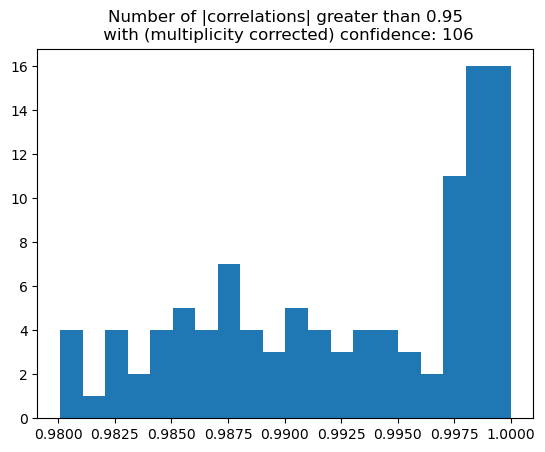

In [98]:
# Plot the correlation matrix
#plt.hist(cor_vector)
plt.hist(cor_vector[CI_mask_vector], bins=20)
# as a title, put the number of significant correlations
plt.title("Number of |correlations| greater than 0.95\n with (multiplicity corrected) confidence: {}".format(np.sum(CI_mask_vector)))
plt.show()

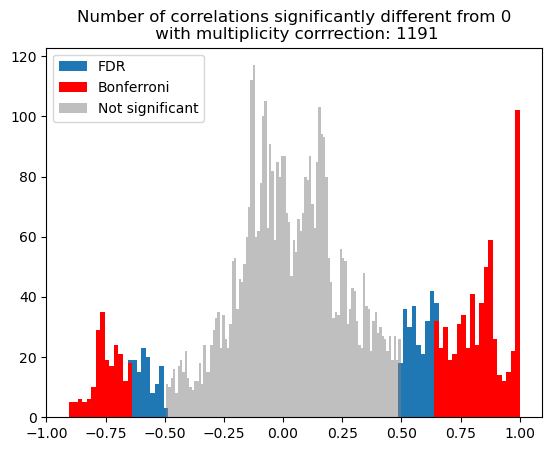

In [99]:
plt.hist(result_correlation_test['corrcoef'][fdr_mask], bins=100)
plt.hist(result_correlation_test['corrcoef'][bonferroni_mask], bins=100, color='r')
plt.hist(result_correlation_test['corrcoef'][~fdr_mask], bins=100, color='gray', alpha=0.5)
# add color explanation
plt.legend(['FDR', 'Bonferroni', 'Not significant'])
# add title to explain the number of significant correlations (significantly different from 0)
plt.title("Number of correlations significantly different from 0\n with multiplicity corrrection: {}".format(np.sum(fdr_mask)))
plt.show()

### Clustering based on correlations

In [129]:
X_std = StandardScaler().fit_transform(AREA.T).T
cov_mat =np.cov(X_std, ddof=0)
COR = np.cov(X_std, ddof=0)

In [131]:
COR

array([[ 1.        ,  0.26934024,  0.03913041, ..., -0.15124087,
        -0.17836585, -0.36107921],
       [ 0.26934024,  1.        , -0.20387861, ..., -0.62795374,
        -0.78653218, -0.80096006],
       [ 0.03913041, -0.20387861,  1.        , ...,  0.44218059,
         0.34196914, -0.24128852],
       ...,
       [-0.15124087, -0.62795374,  0.44218059, ...,  1.        ,
         0.92183313,  0.44453847],
       [-0.17836585, -0.78653218,  0.34196914, ...,  0.92183313,
         1.        ,  0.66444984],
       [-0.36107921, -0.80096006, -0.24128852, ...,  0.44453847,
         0.66444984,  1.        ]])

In [130]:
cov_mat

array([[ 1.        ,  0.26934024,  0.03913041, ..., -0.15124087,
        -0.17836585, -0.36107921],
       [ 0.26934024,  1.        , -0.20387861, ..., -0.62795374,
        -0.78653218, -0.80096006],
       [ 0.03913041, -0.20387861,  1.        , ...,  0.44218059,
         0.34196914, -0.24128852],
       ...,
       [-0.15124087, -0.62795374,  0.44218059, ...,  1.        ,
         0.92183313,  0.44453847],
       [-0.17836585, -0.78653218,  0.34196914, ...,  0.92183313,
         1.        ,  0.66444984],
       [-0.36107921, -0.80096006, -0.24128852, ...,  0.44453847,
         0.66444984,  1.        ]])

In [127]:
np.corrcoef(AREA)

array([[ 1.        ,  0.26934024,  0.03913041, ..., -0.15124087,
        -0.17836585, -0.36107921],
       [ 0.26934024,  1.        , -0.20387861, ..., -0.62795374,
        -0.78653218, -0.80096006],
       [ 0.03913041, -0.20387861,  1.        , ...,  0.44218059,
         0.34196914, -0.24128852],
       ...,
       [-0.15124087, -0.62795374,  0.44218059, ...,  1.        ,
         0.92183313,  0.44453847],
       [-0.17836585, -0.78653218,  0.34196914, ...,  0.92183313,
         1.        ,  0.66444984],
       [-0.36107921, -0.80096006, -0.24128852, ...,  0.44453847,
         0.66444984,  1.        ]])

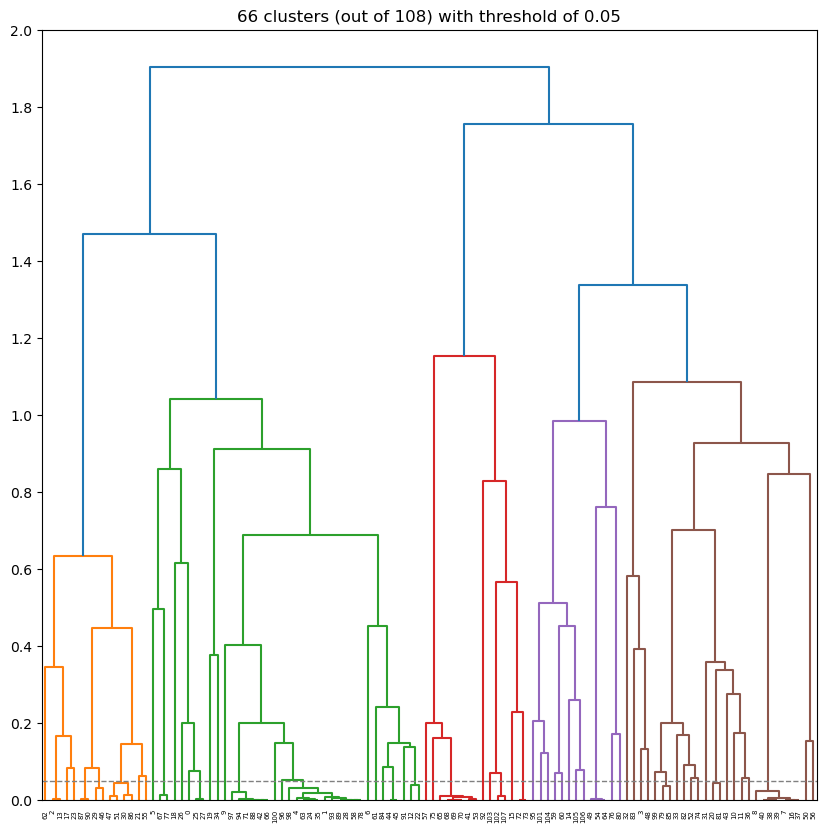

In [23]:
plt.figure(figsize=(10,10))
result_hierarchical = n_eff_cluster(COR, threshold = 0.05, alpha=0.05, method = 'complete', plot = True, return_labels = True, factor = 1) 

#### Get the M_eff and corrected significance level from the results

In [24]:
M_eff = result_hierarchical['M_eff']
alpha_Bonf = result_hierarchical['Bonferroni']
alpha_Sidak = result_hierarchical['Sidak']
print("Effective number of features: ", M_eff)
print("Effective number of tests: ", M_eff*n_patterns)
print("Bonferroni corrected significance level: %.8f" % alpha_Bonf)
print("Sidak corrected significance level: %.8f" % alpha_Sidak)
print(LINEMARK)

Effective number of features:  66
Effective number of tests:  396
Bonferroni corrected significance level: 0.00075758
Sidak corrected significance level: 0.00077687
---------------------------------------------------------------------------------------


## M_eff estimation technique 1

**Adjusting multiple testing in multilocus analyses using the eigenvalues of a correlation matrix**

https://www.nature.com/articles/6800717

$f(X) = I(x\geq0)  + (x - floor(x)), x>0$

In [349]:
f = lambda x: int(x>=1) + x - np.floor(x)
eigvals = np.real(np.linalg.eig(cov_mat)[0])
M_eff1 = np.sum([f(elem) for elem in eigvals])

In [350]:
print("Effective number of tests: ", M_eff1)
print("Sidak alpha: %.8f" % (1-(1-ALPHA)**(1/COR.shape[0])))
print("Sidak alpha with M_eff: %.8f" %  (1-(1-ALPHA)**(1/M_eff1)))
print("Bonferroni alpha: %.8f" % (ALPHA/cov_mat.shape[0]))
print("Bonferroni alpha with M_eff: %.8f" % (ALPHA/M_eff1))

Effective number of tests:  60.76923076923086
Sidak alpha: 0.00047483
Sidak alpha with M_eff: 0.00084371
Bonferroni alpha: 0.00046296
Bonferroni alpha with M_eff: 0.00082278


In [352]:
print("Bonferroni alpha with all features: %.8f" % (ALPHA/cov_mat.shape[0]))
print("Bonferroni alpha with M_eff: %.8f" % (ALPHA/M_eff1))

Bonferroni alpha with all features: 0.00046296
Bonferroni alpha with M_eff: 0.00082278


## M_eff estimation technique 2

**Cheverud (2001)**

$V(\lambda) = \sum_{i=1}^{M}(\lambda_i - 1)^2/(M-1)$

In [353]:
V = lambda λ: 1/(len(λ)-1)*(λ-1)@(λ-1)
M_eff2 = 1 + (len(eigvals)-1)*(1-V(eigvals)/len(eigvals))

In [354]:
print("Effective number of tests: ", M_eff2)
print("Sidak alpha: %.8f" % (1-(1-ALPHA)**(1/cov_mat.shape[0])))
print("Sidak alpha with M_eff: %.8f" %  (1-(1-ALPHA)**(1/M_eff2)))

Effective number of tests:  90.57541655423555
Sidak alpha: 0.00047483
Sidak alpha with M_eff: 0.00056614


In [355]:
print("Bonferroni alpha with all features: %.8f" % (ALPHA/cov_mat.shape[0]))
print("Bonferroni alpha with M_eff: %.8f" % (ALPHA/M_eff2))

Bonferroni alpha with all features: 0.00046296
Bonferroni alpha with M_eff: 0.00055203


### Other techniques

 https://www.nature.com/articles/6889010

In [356]:
M = len(eigvals)
M_eff3 = M*(1 - (M - 1)*np.var(eigvals) / M**2)
M_eff3

90.73740666442747

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1181954/

In [357]:
M_eff4 = 1 + (M - 1)*(1 - np.var(eigvals) / M)
M_eff4

90.73740666442747

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-021-03975-2

Running on 16 cores
Time elapsed:  19.03199791908264
MWSL: 0.00033590
ENT: 148.85182148
R: 0.25532045
MWSL CI: (0.00032822, 0.00034171)


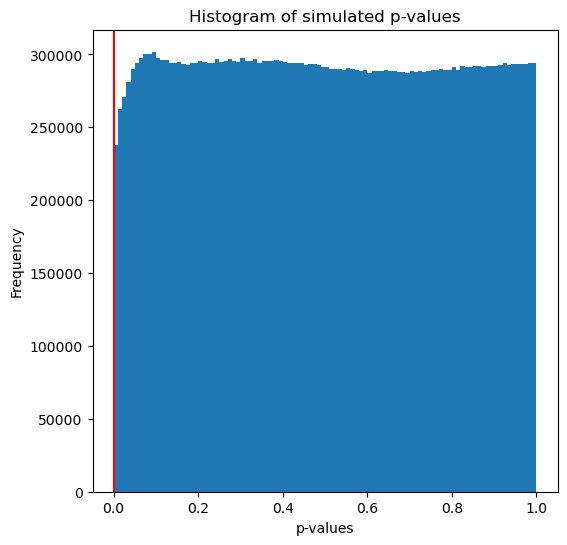

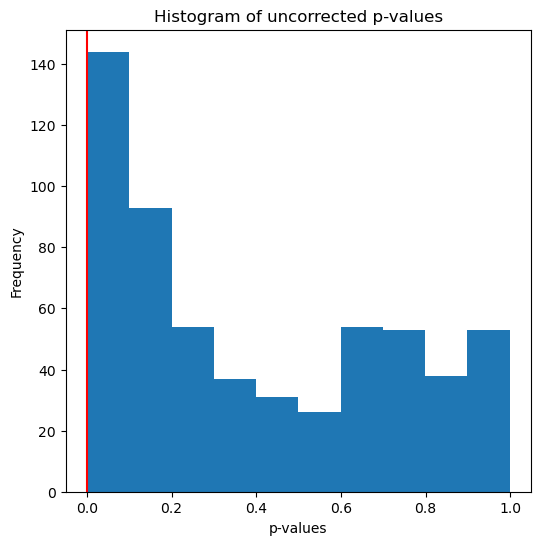

In [25]:
result_MWSL = MWSL_parallel(dataX, dataY, alpha = 0.05, K=int(5e4))
print("MWSL: %.8f" % result_MWSL['MWSL'])
print("ENT: %.8f" % result_MWSL['ENT'])
print("R: %.8f" % result_MWSL['R'])
print("MWSL CI: (%.8f, %.8f)" % (result_MWSL['MWSL_CI'][0], result_MWSL['MWSL_CI'][1]))
plt.figure(figsize=(6,6))
plt.hist(result_MWSL['all_pvalues'].flatten(), bins = 100)
plt.axvline(result_MWSL['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of simulated p-values')
plt.show()
# plot the uncorrected p-values
plt.figure(figsize=(6,6))
plt.hist(p_uncorrected, bins = 10)
plt.axvline(result_MWSL['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of uncorrected p-values')
plt.show()

In [29]:
print("Number of discoveries with MWSL: ", np.sum(p_uncorrected < result_MWSL['MWSL']))
print("Number of discoveries with B-Y corrected p-values: ", np.sum(p_corrected < ALPHA))
print("Number of discoveries based on Sidak correction: ", np.sum(p_uncorrected < alphacSidak))
print("Number of discoveries based on Bonferroni correction: ", np.sum(p_uncorrected < alphacBonf)) 

Number of discoveries with MWSL:  25
Number of discoveries with B-Y corrected p-values:  25
Number of discoveries based on Sidak correction:  17
Number of discoveries based on Bonferroni correction:  16


K not specified, using K = n/2*M =  5830
Running on 16 cores
Time elapsed:  9.732996940612793
MWSL: 0.00008960
ENT: 558.02704132
R: 0.95716474
MWSL CI: (0.00007916, 0.00009690)


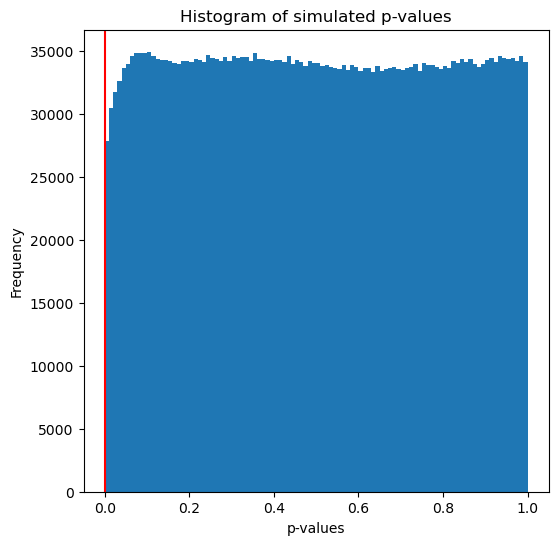

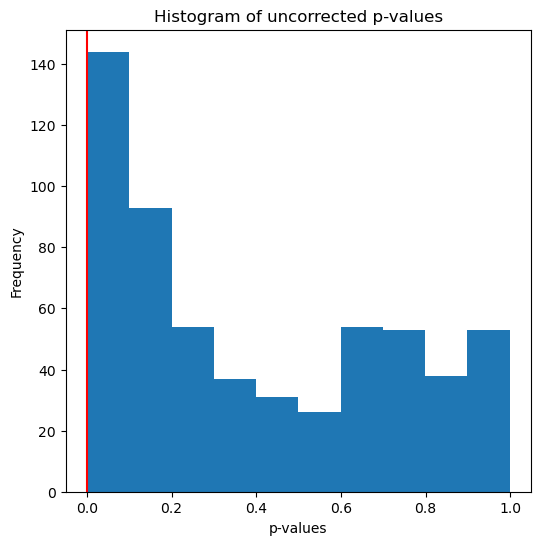

In [41]:
# do the same with parallel processing
result_MWSL_parallel = MWSL_independent_parallel(dataX, dataY, alpha = 0.05)
print("MWSL: %.8f" % result_MWSL_parallel['MWSL'])
print("ENT: %.8f" % result_MWSL_parallel['ENT'])
print("R: %.8f" % result_MWSL_parallel['R'])
print("MWSL CI: (%.8f, %.8f)" % (result_MWSL_parallel['MWSL_CI'][0], result_MWSL_parallel['MWSL_CI'][1]))
plt.figure(figsize=(6,6))
plt.hist(result_MWSL_parallel['all_pvalues'].flatten(), bins = 100)
plt.axvline(result_MWSL_parallel['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of simulated p-values')
plt.show()

# plot the uncorrected p-values
plt.figure(figsize=(6,6))
plt.hist(p_uncorrected, bins = 10)
plt.axvline(result_MWSL_parallel['MWSL'], color = 'red')
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of uncorrected p-values')
plt.show()

In [39]:
print("Number of discoveries with MWSL: ", np.sum(p_uncorrected < result_MWSL_parallel['MWSL']))
print("Number of discoveries with B-Y corrected p-values: ", np.sum(p_corrected < ALPHA))
print("Number of discoveries based on Sidak correction: ", np.sum(p_uncorrected < alphacSidak))
print("Number of discoveries based on Bonferroni correction: ", np.sum(p_uncorrected < alphacBonf)) 

Number of discoveries with MWSL:  17
Number of discoveries with B-Y corrected p-values:  25
Number of discoveries based on Sidak correction:  17
Number of discoveries based on Bonferroni correction:  16
